In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
Epoch 1/30, Train Loss: 0.4290, Train Acc: 0.7938, Val Loss: 0.6236, Val Acc: 0.8113, Precision: 0.8494, Recall: 0.8113, F1 Score: 0.7664
Best model saved.
Epoch 2/30, Train Loss: 0.2054, Train Acc: 0.9171, Val Loss: 2.2858, Val Acc: 0.4434, Precision: 0.8253, Recall: 0.4434, F1 Score: 0.4228
Early stopping counter: 1/5
Epoch 3/30, Train Loss: 0.1517, Train Acc: 0.9384, Val Loss: 0.3640, Val Acc: 0.8208, Precision: 0.8556, Recall: 0.8208, F1 Score: 0.8292
Best model saved.
Epoch 4/30, Train Loss: 0.0853, Train Acc: 0.9668, Val Loss: 0.5550, Val Acc: 0.9151, Precision: 0.9147, Recall: 0.9151, F1 Score: 0.9121
Early stopping counter: 1/5
Epoch 5/30, Train Loss: 0.0942, Train Acc: 0.9858, Val Loss: 0.4774, Val Acc: 0.8208, Precision: 0.8158, Recall: 0.8208, F1 Score: 0.7992
Early stopping counter: 2/5
Epoch 6/30, Train Loss: 0.1109, Train Acc: 0.9573, Val Loss: 1.3865, Val Acc: 0.5472, Precision: 0.8134, Recall: 0.5472, F1 Score: 0.5583
Early stopping counter: 3/5
Epoch

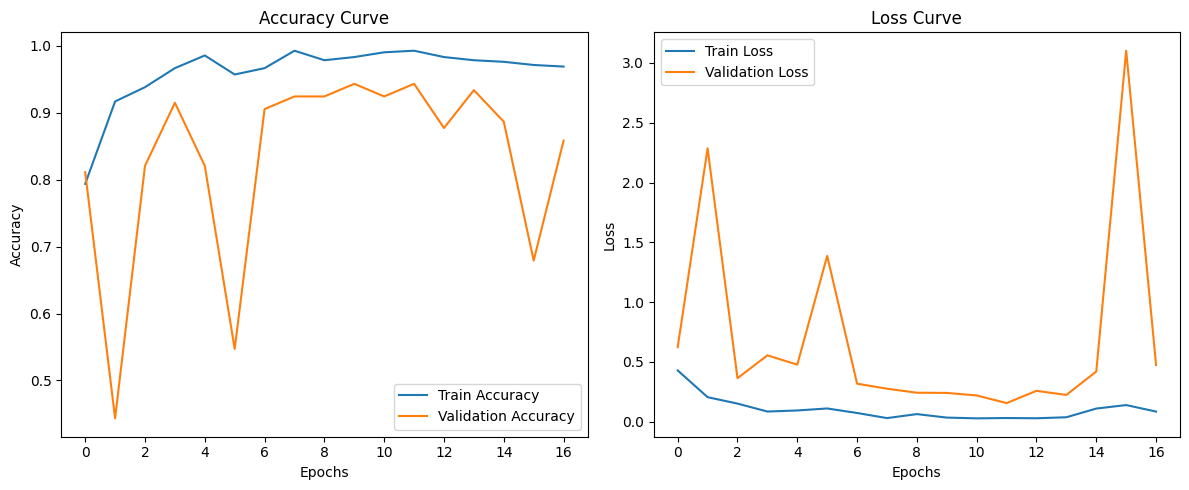

<ipython-input-2-b772edcd5659>:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_inception_resnet_v2.pth"))



--- Final Evaluation Metrics on Validation Set ---
Accuracy: 0.9434
Precision: 0.9440
Recall: 0.9434
F1 Score: 0.9418


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import timm  # For InceptionResNetV2

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
dataset_path = "/kaggle/input/histopathological/First Set"

# Hyperparameters
num_epochs = 30
batch_size = 32
learning_rate = 0.001
num_classes = 2  # Normal and OSCC
early_stop_patience = 5

# Data transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # InceptionResNetV2 requires 299x299 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Splitting the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained InceptionResNetV2 model
model = timm.create_model('inception_resnet_v2', pretrained=True)
model.classif = nn.Linear(model.classif.in_features, num_classes)  # Adjust classifier
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping setup
best_val_loss = float('inf')
early_stop_counter = 0

# Training and validation loop
train_acc, val_acc = [], []
train_loss, val_loss = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss, correct_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()

    train_acc.append(correct_train / len(train_dataset))
    train_loss.append(total_train_loss / len(train_loader))

    # Validation
    model.eval()
    total_val_loss, correct_val = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_acc.append(correct_val / len(val_dataset))
    val_loss.append(total_val_loss / len(val_loader))

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    acc = accuracy_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
          f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Early stopping
    if val_loss[-1] < best_val_loss:
        best_val_loss = val_loss[-1]
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model_inception_resnet_v2.pth")  # Save the best model
        print("Best model saved.")
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{early_stop_patience}")

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered. Stopping training.")
        break

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Load the best saved model
model.load_state_dict(torch.load("best_model_inception_resnet_v2.pth"))
model.eval()

all_labels, all_preds = [], []

# Evaluate on the validation set
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
final_precision = precision_score(all_labels, all_preds, average='weighted')
final_recall = recall_score(all_labels, all_preds, average='weighted')
final_f1 = f1_score(all_labels, all_preds, average='weighted')

print("\n--- Final Evaluation Metrics on Validation Set ---")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
